# Digit Recognizer 
A fast.ai implementation for the MNIST Digit Recognizer competition on kaggle. https://www.kaggle.com/c/digit-recognizer 

In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy,error_rate

Below is a custom `ImageItemList` that allows us to load the kaggle datasets. Essentially, the images are stored as a label plus a pixel array wrapped up in a csv file.

In [2]:
# in newer versions of fastai this is just called ImageList now
class CustomImageItemList(ImageItemList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1) # convert to 3 channels
        return Image(pil2tensor(img, dtype=np.float32))

    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx:int=1, header:str='infer', **kwargs)->'ItemList':
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        # convert pixels to an ndarray
        res.items = df.iloc[:,imgIdx:].apply(lambda x: x.values / 255.0, axis=1).values
        return res

## Training
found something somewhere that caused me to set `num_workers` equal to zero. Was getting an error and at the end of the day it seems it was pytorch/windows thing and that was the work around.

In [3]:
# note: there are no labels in a test set, so we set the imgIdx to begin at the 0 col
test = CustomImageItemList.from_csv_custom(path='./data', csv_name='test.csv', imgIdx=0)

todo: need to look into how I'm generating transforms for data augmentation - for some reason transforms are hurting performance

In [4]:
tfms = get_transforms(do_flip=False)
data = (CustomImageItemList.from_csv_custom(path='./data', csv_name='train.csv')
                           .random_split_by_pct(.2)
                           .label_from_df(cols='label')
                           .add_test(test, label=0)
                           .transform(tfms)
                           .databunch(bs=64, num_workers=0)
                           .normalize(imagenet_stats))

## Resnet34

In [23]:
learn = create_cnn(data, arch=models.resnet34, metrics=[accuracy,error_rate])

**Stage 1:** basic model fit

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


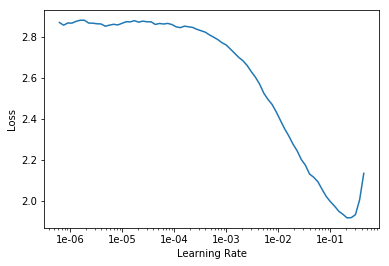

In [6]:
learn.lr_find()
learn.recorder.plot()

In [7]:
lr = 1e-2
learn.fit_one_cycle(8, lr)

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.223269,0.131689,0.958809,0.041190
2,0.158392,0.177087,0.949048,0.050952
3,0.143830,0.097679,0.971667,0.028333
4,0.075972,0.102950,0.970000,0.030000
5,0.065660,0.038177,0.988095,0.011905
6,0.042660,0.033664,0.989524,0.010476
7,0.026621,0.026870,0.991548,0.008452
8,0.019415,0.025018,0.991667,0.008333


In [8]:
learn.save('resnet34-stage-1')

**Stage 2:** unfreezing the entire model to try and tweak things to squeeze out just a bit of extra performance

In [24]:
learn.load('resnet34-stage-1')
learn.validate()

[0.025018422, tensor(0.9917), tensor(0.0083)]

In [25]:
learn.unfreeze()
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.078461,0.096700,0.969643,0.030357
2,0.061080,0.053780,0.983571,0.016429
3,0.029313,0.028203,0.990357,0.009643
4,0.012527,0.021197,0.993810,0.006190


## Resnet50

In [5]:
learn = create_cnn(data, arch=models.resnet50, metrics=[accuracy,error_rate])

**Stage 1:** basic model fit

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


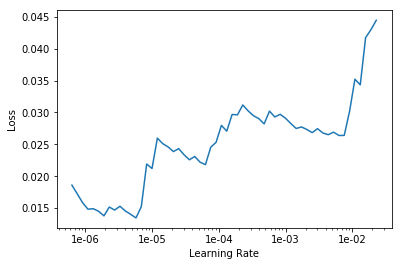

In [11]:
learn.lr_find()
learn.recorder.plot()

In [11]:
lr = 1e-2
learn.fit_one_cycle(8, lr)

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.221126,0.156132,0.952381,0.047619
2,0.155884,0.237217,0.935119,0.064881
3,0.117589,0.133768,0.964048,0.035952
4,0.084941,0.040231,0.989286,0.010714
5,0.051596,0.040551,0.988333,0.011667
6,0.035350,0.032618,0.990119,0.009881
7,0.020701,0.024983,0.992143,0.007857
8,0.018151,0.024436,0.992381,0.007619


In [12]:
learn.save('resnet50-stage-1')

**Stage 2:** unfreezing the entire model to try and tweak things to squeeze out just a bit of extra performance

In [6]:
learn.load('stage1-resnet50')
learn.validate()

[0.013592077, tensor(0.9948), tensor(0.0052)]

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate


## Interpreting Results

In [13]:
learn = create_cnn(data, arch=models.resnet50, metrics=[accuracy,error_rate])
learn.load('resnet50-stage-1')
learn.validate()

[0.024436072, tensor(0.9924), tensor(0.0076)]

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

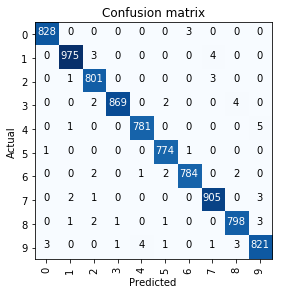

In [15]:
interp.plot_confusion_matrix()

In [16]:
interp.most_confused()

[(4, 9, 5),
 (1, 7, 4),
 (3, 8, 4),
 (9, 4, 4),
 (0, 6, 3),
 (1, 2, 3),
 (2, 7, 3),
 (7, 9, 3),
 (8, 9, 3),
 (9, 0, 3),
 (9, 8, 3),
 (3, 2, 2),
 (3, 5, 2),
 (6, 2, 2),
 (6, 5, 2),
 (6, 8, 2),
 (7, 1, 2),
 (8, 2, 2)]

## Generate Competition File

In [7]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

In [8]:
res_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
res_df.to_csv(f'./data/digit-recognition-submission.csv', index=False)